In [13]:
from cfl.experiment import Experiment
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from cfl_helpers import *

In [14]:
file = 'data/10km_data.csv'

data = pd.read_csv(file)
Xraw = np.array(data[['lat', 'long']])
Yraw = np.array(data['generated_temp']).reshape(-1,1)
X = StandardScaler().fit_transform(Xraw)
Y = StandardScaler().fit_transform(Yraw)

In [15]:
true_alt, true_temps = get_alt_temp_grids(data)

In [16]:
# Create 3 dictionaries: one for data info, one with CDE parameters, and one with cluster parameters

# the parameters should be passed in dictionary form
data_info = {'X_dims' : X.shape,
             'Y_dims' : Y.shape,
             'Y_type' : 'continuous' #options: 'categorical' or 'continuous'
            }

# VARYING CDE PARAMS

# cluster_params consists of specifying two clustering objects
# CFL automatically recognizes the names of all sklearn.cluster models as keywords
cause_cluster_params =  {'model' : 'KMeans',
                         'model_params' : {'n_clusters' : 100},
                         'verbose' : 0
}

# NN architecture vs accuracy on linear func temp

In [ ]:
import math

nn_depths = [2, 3, 4] # can just run 1 layer in run_cfl
decrease_increase = ['decrease', 'increase', 'const']
abs_accuracies = {option:[] for option in decrease_increase}
sq_accuracies = {option:[] for option in decrease_increase}

for depth in nn_depths:
    for option in decrease_increase:

        max_layer = 50*(depth)
        layers = [math.floor(max_layer/(2**i)) for i in range(depth)]
        if option == 'const':
            layers = [math.floor(max_layer/2) for _ in range(depth)]
        if option == 'increase':
            layers = layers[::-1]
        dense_units = layers + [data_info['Y_dims'][1]]
        
        activations = ['relu'] + ['linear' for _ in range(depth)]
        dropouts = [0 for _ in range(depth+1)]

        CDE_params = {  'model'        : 'CondExpMod',
                        'model_params' : {
                            # model architecture
                            'dense_units' : dense_units,
                            'activations' : activations,
                            'dropouts'    : dropouts,
                            # training parameters
                            'batch_size'  : 64,
                            'n_epochs'    : 2000,
                            'optimizer'   : 'adam',
                            'opt_config'  : {'lr' : 1e-4},
                            'loss'        : 'mean_squared_error',
                            'best'        : True,
                            'early_stopping' : True,
                            # verbosity
                            'verbose'     : 0, # no verbosity for testing
                            'show_plot'   : False,
                        }
        }

        block_names = ['CondDensityEstimator', 'CauseClusterer']
        block_params = [CDE_params, cause_cluster_params]
        results_path = 'sample_run' # directory to save results to

        my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)
        results = my_exp.train()

        xlbls = results['CauseClusterer']['x_lbls']
        pred_alts = reconstruct_groups(data, xlbls, plot=False)

        abs_accuracies[option].append(err(true_alt, pred_alts, 'mean_abs'))
        sq_accuracies[option].append(err(true_alt, pred_alts, 'mean_squared'))
        print(f'Accuracy for {depth} layers with {option} dense units: {abs_accuracies[option][-1]}')

All results from this run will be saved to sample_run/experiment0008
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
397/397 [==============================] - 0s 696us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
Accuracy for 2 layers with decrease dense units: 83.0923916539317
All results from this run will be saved to sample_run/experiment0009
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
397/397 [==============================] - 0s 735us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.
Accuracy for 2 layers with increase dense units: 7

In [25]:
# get one layer accuracy for comparison

CDE_params = {  'model'        : 'CondExpMod',
                'model_params' : {
                    # model architecture
                    'dense_units' : [50, data_info['Y_dims'][1]],
                    'activations' : ['relu', 'linear'],
                    'dropouts'    : [0, 0],
                    # training parameters
                    'batch_size'  : 64,
                    'n_epochs'    : 2000,
                    'optimizer'   : 'adam',
                    'opt_config'  : {'lr' : 1e-4},
                    'loss'        : 'mean_squared_error',
                    'best'        : True,
                    'early_stopping' : True,
                    # verbosity
                    'verbose'     : 0, # no verbosity for testing
                    'show_plot'   : False,
                }
}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]
results_path = 'sample_run' # directory to save results to

my_exp = Experiment(X_train=X,
                    Y_train=Y,
                    data_info=data_info,
                    block_names=block_names,
                    block_params=block_params,
                    results_path=results_path)
results = my_exp.train()

xlbls = results['CauseClusterer']['x_lbls']
pred_alts = reconstruct_groups(data, xlbls, plot=False)

one_layer_abs_err = err(true_alt, pred_alts, 'mean_abs')
one_layer_sq_err = err(true_alt, pred_alts, 'mean_squared')

save_path 'sample_run' doesn't exist, creating now.
All results from this run will be saved to sample_run/experiment0000
Block: verbose not specified in input, defaulting to 1
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
397/397 [==============================] - 0s 988us/step
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


([<matplotlib.axis.XTick at 0x14906ed10>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

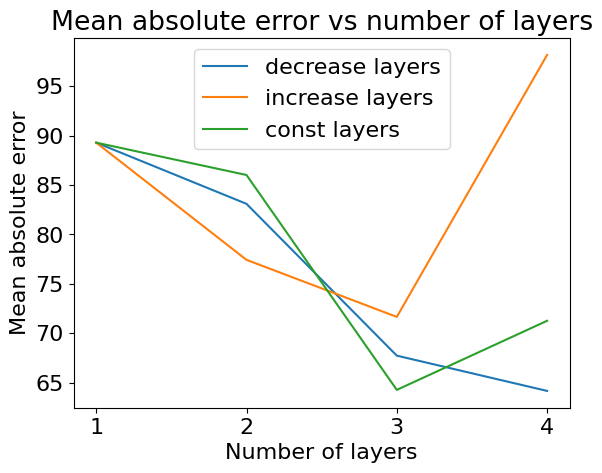

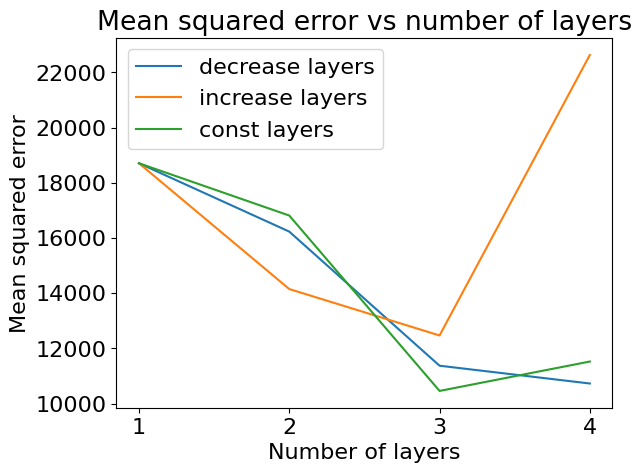

In [26]:
import matplotlib.pyplot as plt

plt.figure(0)
for option in decrease_increase:
    plt.plot([1] + nn_depths, [one_layer_abs_err] + abs_accuracies[option], label=f'{option} layers')
plt.xlabel('Number of layers')
plt.ylabel('Mean absolute error')
plt.title('Mean absolute error vs number of layers')
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.figure(1)
for option in decrease_increase:
    plt.plot([1] + nn_depths, [one_layer_sq_err] + sq_accuracies[option], label=f'{option} layers')
plt.xlabel('Number of layers')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of layers')
plt.legend()
plt.xticks([1, 2, 3, 4])